#### 1.3.3 Data organization and standardization

Libraries for creating the dataset:

In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

The following code reads the cropped images and organizes into a random sequenced tuple structure based on the label.

(25191, 32, 32, 3)
It is not a mole.


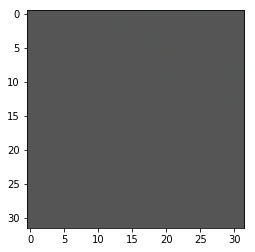

In [2]:
imgs = []
labels = []
i = 0
for file_path in glob.glob('Cropped/*.bmp'):  # grabbing path of the cropped images
    if file_path:
        img = np.asarray(Image.open(file_path))  # reading mole images and labels
        #imgs[i] = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2YCrCb)
        if np.sum(img,2).min()==0:
            print(img)
        imgs.append(np.divide(img, np.sum(img,2)[:,:,None]))
        labels.append(1)  # reading background images and labels
        i += 1
# imgs = copy(imgs[:-1])

del imgs[-1]
del labels[-1]

i = 0
for file_path in glob.glob('CroppedBCKG/*.bmp'):  # grabbing path of the cropped images
    if file_path:
        img = np.asarray(Image.open(file_path))  # reading mole images and labels
#         imgs[i] = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2YCrCb)
        if np.sum(img,2).min()!=0:
            imgs.append(np.divide(img, np.sum(img,2)[:,:,None]))
            labels.append(0)  # reading background images and labels
            i += 1
# imgs = copy(imgs[:-1])
del imgs[-1]
del labels[-1]


imgs = np.asarray(imgs)
print(imgs.shape)
# print(imgs[0])
# imgs = imgs[:,:,:,1:]
labels = np.asarray(labels)
    
s = np.arange(len(imgs))
np.random.shuffle(s)
imgs = imgs[s]
labels = labels[s]

dataset = [imgs, labels]

#Example:
#Second dim: i-th image
#First dim: 0 - image data; 1 - label data
plt.imshow(dataset[0][0])
if dataset[1][0]==1:
    print('It is a mole.')
else:
    print('It is not a mole.')
    
# organize the dataset into a tuple
dataset = (dataset[0], dataset[1])

<h2 align="center">II. milestone</h2>

### 2.1 Train

Import packages for training.

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras import backend as K
from keras import regularizers
from keras.utils import np_utils

Using TensorFlow backend.


#### 2.1.1 preprocess
The following code separates the dataset into validation, test and train subsets. Based on the training set standardization executed on the three sets.

In [4]:
# mole or not mole
nb_classes = 2

# separating inputs and outputs
X, Y = dataset

# ratio of validation samples
test_split = 0.1
valid_split = 0.1

#Indeces of the subsets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

#Splitting the dataset into test, validation and train subsets
X_train = X[:t_index].astype('float32')
Y_train = Y[:t_index]
X_valid = X[v_index:t_index].astype('float32')
Y_valid = Y[v_index:t_index]
X_test = X[t_index:].astype('float32')
Y_test = Y[t_index:]

# dimensions of our images.
img_width, img_height = X_train.shape[1], X_train.shape[2]

# standard
#X_train = X_train / 255
#X_valid = X_valid / 255
#X_test = X_test / 255

print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())
print('X_valid max: ',X_valid.max())
print('X_valid min: ',X_valid.min())
print('X_test max: ',X_test.max())
print('X_test min: ',X_test.min())

print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X valid shape: ', X_valid.shape)
print('Y valid shape: ', Y_valid.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)
print(X_train.shape[0], 'train samples')

X_train max:  1.0
X_train min:  0.0
X_valid max:  1.0
X_valid min:  0.0
X_test max:  1.0
X_test min:  0.0
X train shape:  (22671, 32, 32, 3)
Y train shape:  (22671,)
X valid shape:  (2519, 32, 32, 3)
Y valid shape:  (2519,)
X test shape:  (2520, 32, 32, 3)
Y test shape:  (2520,)
22671 train samples


one hot encoded & channel format

In [5]:
# convert class vectors to binary class matrices:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_valid = np_utils.to_categorical(Y_valid, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_width, img_height)
    X_valid = X_valid.reshape(X_valid.shape[0], 3, img_width, img_height)
    X_test = X_test.reshape(X_test.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_height)
else:
    X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 3)
    X_valid = X_valid.reshape(X_valid.shape[0], img_width, img_height, 3)
    X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 3)
    input_shape = (img_width, img_height, 3)

In [91]:
# datagen_train = ImageDataGenerator(rotation_range=20, horizontal_flip=True, height_shift_range=0.2, width_shift_range=0.2, shear_range=10)
datagen_train = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

datagen_train.fit(X_train)
X_test = datagen_train.standardize(X_train)
X_test = datagen_train.standardize(X_test)
X_valid = datagen_train.standardize(X_valid)

# i=0
# for batch in datagen_train.flow(X_train, Y_train, batch_size=32, save_to_dir='preview', save_prefix='mole', save_format='bmp'):
#     i += 1

#### 2.1.2 Define CNN

The convnet by https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

<i>"The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU)."</i>

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='sigmoid'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
__________

#### 2.1.3 Train

In [7]:
batch_size = 32
epochs = 100

# Next, setting the early stopping
# and define checkpoint, so we can load the best state back
patience = 4
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='Weights/cnn_normalised_weights.hdf5', save_best_only=True, verbose=1)

# network_history = model.fit_generator(datagen_train.flow(X_train, Y_train, batch_size=batch_size),
#                                       steps_per_epoch=len(X_train) / 32,
#                                       epochs=epochs,
#                                       verbose=1,
#                                       validation_data=(X_valid, Y_valid),
#                                       callbacks=[checkpointer, early_stopping])

network_history = model.fit(X_train, Y_train,
                           epochs=epochs,
                           verbose=1,
                           validation_data=(X_valid, Y_valid),
                           callbacks=[checkpointer, early_stopping])

Train on 22671 samples, validate on 2519 samples
Epoch 1/100
22671/22671 [==============================] - 6s 275us/step - loss: 0.3866 - acc: 0.8418 - val_loss: 0.2809 - val_acc: 0.8984

Epoch 00001: val_loss improved from inf to 0.28088, saving model to Weights/cnn_normalised_weights.hdf5
Epoch 2/100
22671/22671 [==============================] - 4s 170us/step - loss: 0.2702 - acc: 0.9023 - val_loss: 0.2380 - val_acc: 0.9107

Epoch 00002: val_loss improved from 0.28088 to 0.23799, saving model to Weights/cnn_normalised_weights.hdf5
Epoch 3/100
22671/22671 [==============================] - 4s 167us/step - loss: 0.2286 - acc: 0.9209 - val_loss: 0.1950 - val_acc: 0.9230

Epoch 00003: val_loss improved from 0.23799 to 0.19498, saving model to Weights/cnn_normalised_weights.hdf5
Epoch 4/100
22671/22671 [==============================] - 4s 169us/step - loss: 0.1998 - acc: 0.9307 - val_loss: 0.1679 - val_acc: 0.9369

Epoch 00004: val_loss improved from 0.19498 to 0.16792, saving model to

### 2.2 Results

In [8]:
def plot_history(network_history):
    figure = plt.figure(figsize=(20,20))
    figure.add_subplot(2,1,1)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'], fontsize=18)

    figure.add_subplot(2,1,2)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

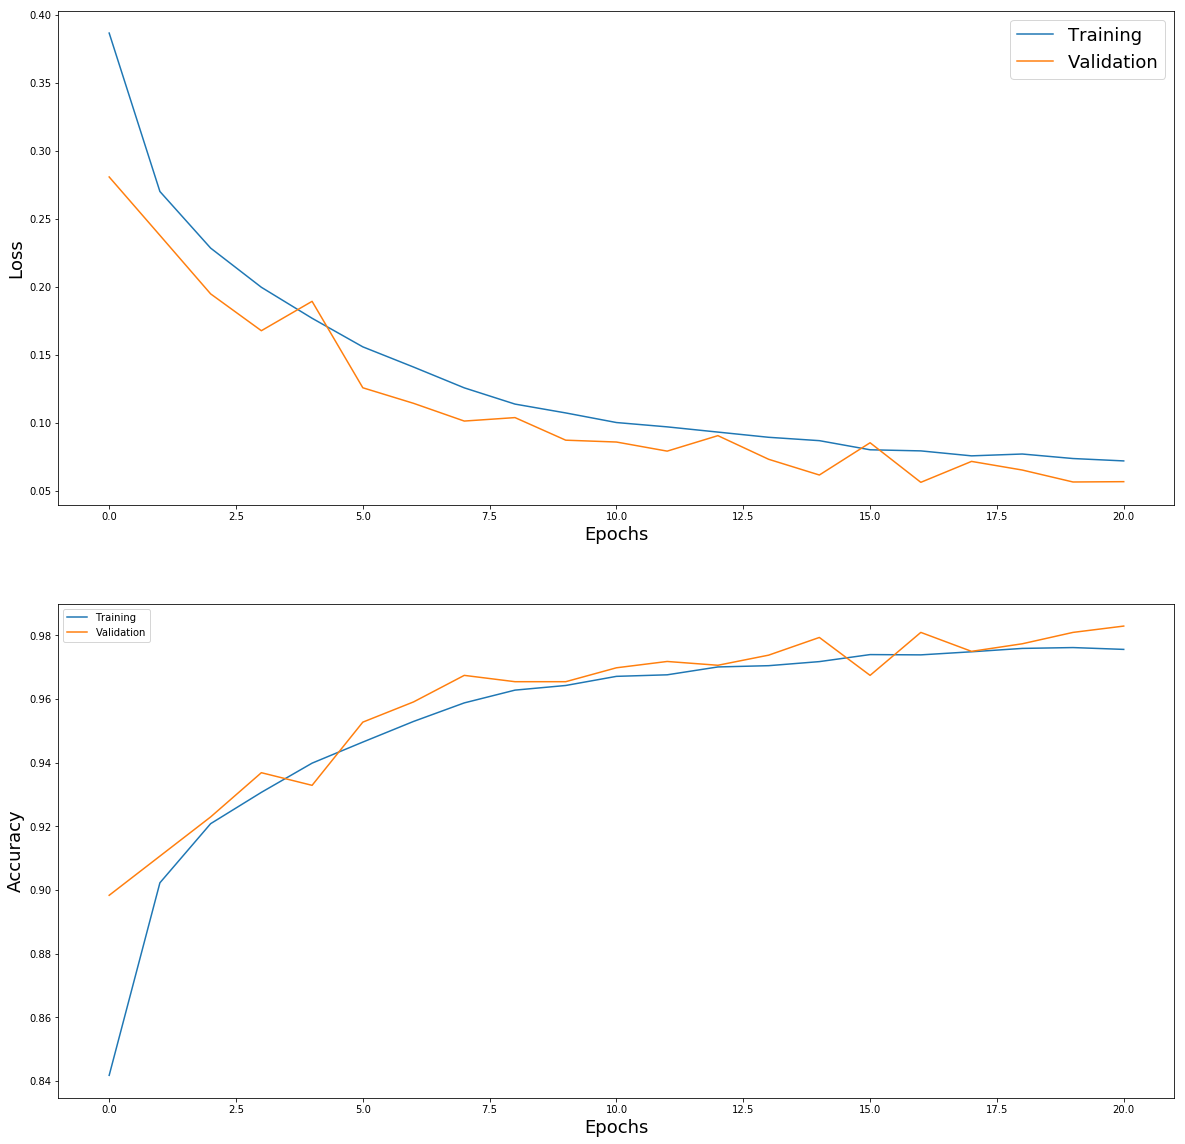

In [9]:
plot_history(network_history)

0.00,  1.00
0.01,  1.00
0.00,  1.00
0.68,  0.03
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.94,  0.03
0.00,  0.96
0.00,  1.00
0.23,  0.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00
0.00,  1.00


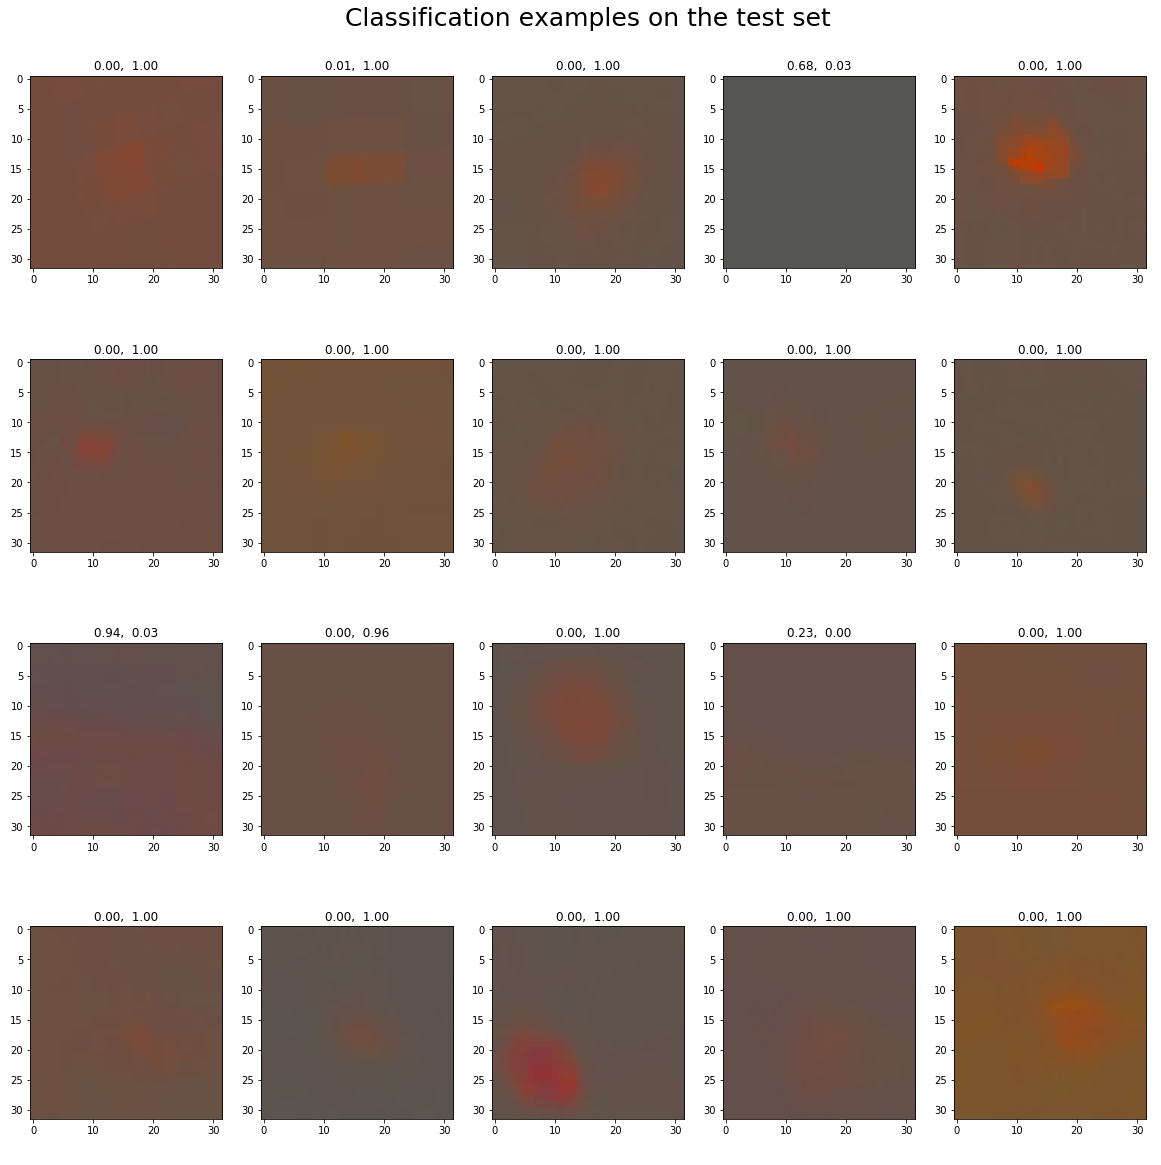

In [11]:
model = load_model('Weights/cnn_normalised_weights.hdf5')
pred = model.predict(X_test[:20])
for p in pred:
    print(str("%0.2f" % np.asscalar(p[0])) + ',  ' + str("%0.2f" % np.asscalar(p[1])))

i=0
figure = plt.figure(figsize=(20,20))
plt.title("Classification examples on the test set", fontsize=25, y=1.02)
plt.axis('off')

for value in pred:
    title = str("%0.2f" % np.asscalar(value[0])) + ',  ' + str("%0.2f" % np.asscalar(value[1]))
    figure.add_subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title(title)
    i+=1

plt.show()